## Data pre-processing to filter the yellow (diagnostic) cards

This notebook takes an arbitrary number of sample yellow cards found within the pictures (27 were used to do the final cleaning) and calculates the mean hue value after resizing and converting the pictures to the HSV color code.
After that all relevant pictures are converted to the HSV color code and their pixel-wise divergence from the reference hue value is determined. If the 55 percentile (allows outliers) is below a certain threshold, the picture is considered a yellow card and is moved towards the defined directories.

<span style="color:red"><strong>Attention: Executing this notebook might move and can possibly overwrite existing files on your computer when not using properly</strong></span>.

### Import Statements

In [291]:
from skimage import io, color
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
import imagehash
import os
import numpy as np
from shutil import copyfile
from time import time

# timer print function
def timed_print(string):
    print("Process   -> {:60s} : {:.2f}s".format(string, time() - start_time))
    
# Define the directories
# examples
examles_path = '../yellow_cards'
# original pictures
psoriasis_path = '../Psoriasis'
eczema_path = '../Eczema'
# paths to store the detected yellow cards and broken images
eczema = '../Eczema_yellow_pages'
eczema_broken_path = '../Eczema_Thrash'
psoriasis_yellowcard_path = '../Psoriasis_yellow_pages'
psoriasis_broken_path = '../Psoriasis_Thrash'

### Calculate the HSV-yellow values for some example yellow-cards

In [292]:
# Look at the example cards and figure out common color values for yellow cards

for file in os.listdir(examles_path):
    file=examles_path + file
    img = io.imread(file)
    # Resize to a 64 pixel picture
    img = resize(img, (8,8))
    # cut of the boarders and scale down to one pixel
    img = img[2:-2,2:-2,:]
    # Converting RGB-colors to HSV-colors
    img = color.rgb2hsv(img)
    # Save the color vectors for the pictures
    try:
        values = np.vstack((values, [img[:,:,0]]))
    except:
        values = [img[:,:,0]]
# Calculate the average color values for the example cards
norm_value = np.mean(values)

/home/lauve/miniconda3/envs/Deep_learning/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Calculate the values for some example pictures and show the examples

In [270]:
# Percentile parameter
percentile = 55

# Look at the in "comparison_number" defined number of pictures and get the HSV color values
# For Eczema

# Number of picture to analyze limiter
count = 0
comparison_number = 200

# Overwriting the variables to ensure they are empty when starting
pict_dist_single=[]
pict_dist=[]
filename_list=[]

# Iterating over the files
for file in os.listdir(eczema_path):
    if not file.startswith("."):
        filename = file
        file = eczema_path + file
        img = io.imread(file)
        # Resize to a 64 pixel picture
        img = resize(img, (8,8))
        # cut of the boarders and scale down to one pixel
        img = img[2:-2,2:-2,:]
        # Converting RGB-colors to HSV-colors
        img = color.rgb2hsv(img)
        try:
            # Saving the pixel color vector
            values2 = np.vstack((values2, np.array(([img]))))
            # Calculate the overall HSV norm 1 color distance to the sample yellow_cards of the actual picture
            dist_now = np.percentile(np.abs(img[:,:,0]-norm_value), percentile)
            # Save the result
            pict_dist = np.vstack((pict_dist, dist_now))
            # Save the filename
            filename_list = np.vstack((filename_list, filename))
        # The except will only be used in the first run when there are no arrays yet
        except:
            # Saving the pixel color vector
            values2 = np.array(([img]))
            # Calculate the overall HSV norm 1 color distance to the sample yellow_cards of the actual picture
            dist_now = np.percentile(np.abs(img[:,:,0]-norm_value), percentile)
            # Save the result
            pict_dist = dist_now
            # Save the filename
            filename_list = np.array(([filename]))
        count += 1
        # Number of pictures limiter
        if count > comparison_number:
            break

/home/lauve/miniconda3/envs/Deep_learning/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


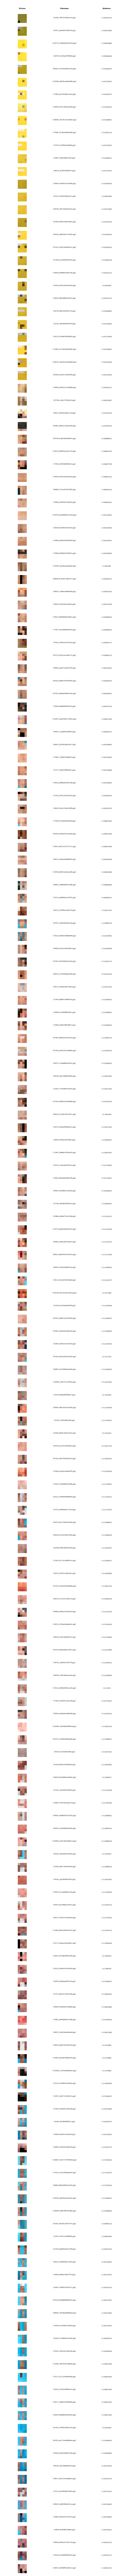

In [271]:
number_to_plot = len(values2)
f, axarr = plt.subplots(number_to_plot+1, 3, figsize=(15, number_to_plot*1.5))
#f.suptitle('Sensitivity analysis', fontsize=14, fontweight='bold')
axarr[0,0].text(0.5,0.1,'Picture',fontsize=14,fontweight='bold',horizontalalignment='center',verticalalignment='bottom')
axarr[0,0].axis('off')
axarr[0,1].text(0.5,0.1,'Filename',fontsize=14,fontweight='bold',horizontalalignment='center',verticalalignment='bottom')
axarr[0,1].axis('off')
axarr[0,2].text(0.5,0.1,'Distance',fontsize=14,fontweight='bold',horizontalalignment='center',verticalalignment='bottom')
axarr[0,2].axis('off')

# Sort after first dimension in hsv
order_list = np.argsort(pict_dist,axis=0)[:,0]
dist_ordered = pict_dist[order_list]
values_ordered = values2[order_list]
filenames_ordered = filename_list[order_list]

for i in range(number_to_plot):
    #Create the plots from the data above
    axarr[i+1,0].imshow(color.hsv2rgb(values_ordered[i]))
    axarr[i+1,0].axis('off')
    axarr[i+1,1].text(0.5,0.5, filenames_ordered[i],fontsize=12,horizontalalignment='center',verticalalignment='bottom')
    axarr[i+1,1].axis('off')
    axarr[i+1,2].text(0.5,0.5, dist_ordered[i],fontsize=12,horizontalalignment='center',verticalalignment='bottom')
    axarr[i+1,2].axis('off')
        
plt.tight_layout()
plt.show()

## This is the Eczema filtering algorithm

In [293]:
# Get the relevant list for Eczema
# Get the H (hue) norm 1 distance for all pictures

# Overwriting the variables to ensure they are empty when starting
h_dist = []
filename_list = []
weird_files_list = []

# Time taking
start_time = time()

#count variable
count = 0

# Iterating over the files
for file in os.listdir(eczema_path):
    if not file.startswith("."):
        filename = file
        file = eczema_path + file
        try:
            img = io.imread(file)
        except:
            if weird_files_list == []:
                weird_files_list = np.array(([filename]))
            else:
                weird_files_list = np.vstack((weird_files_list, filename))
            continue
        # Resize to a 64 pixel picture
        img = resize(img, (8,8))
        # cut of the boarders and scale down to one pixel
        img = img[2:-2,2:-2,:]
        # Converting RGB-colors to HSV-colors
        img = color.rgb2hsv(img)
        try:
            # Calculate the H (hue) norm 1 value distance to the sample yellow_cards of the actual picture
            dist_now = np.percentile(np.abs(img[:,:,0]-norm_value), percentile)
            # Save the result
            h_dist = np.vstack((h_dist, dist_now))
            # Save the filename
            filename_list = np.vstack((filename_list, filename))
        # The except will only be used in the first run when there are no arrays yet
        except:
            # Calculate the H (hue) norm 1 value distance to the sample yellow_cards of the actual picture
            dist_now = np.percentile(np.abs(img[:,:,0]-norm_value), percentile)
            # Save the result
            h_dist = dist_now
            # Save the filename
            filename_list = np.array(([filename]))
        count += 1
        if count%100 == 0:
            timed_print("{} pictures processed so far.".format(count))

/home/lauve/miniconda3/envs/Deep_learning/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Process   -> 100 pictures processed so far.                               : 57.57s
Process   -> 200 pictures processed so far.                               : 117.59s
Process   -> 300 pictures processed so far.                               : 174.43s
Process   -> 400 pictures processed so far.                               : 230.49s
Process   -> 500 pictures processed so far.                               : 290.39s
Process   -> 600 pictures processed so far.                               : 349.75s
Process   -> 700 pictures processed so far.                               : 407.41s
Process   -> 800 pictures processed so far.                               : 466.44s
Process   -> 900 pictures processed so far.                               : 523.72s
Process   -> 1000 pictures processed so far.                              : 581.82s
Process   -> 1100 pictures processed so far.                              : 644.35s
Process   -> 1200 pictures processed so far.                              : 7

In [294]:
# Threshold for the H (hue) norm 1 distance of the comparison pictures
threshold = 0.05
# filtering all filenames that due to their H (hue) norm 1 distance to the example yellow cards
# that have to be sorted out
moving_list = filename_list[h_dist < threshold]

# Move the gold for Eczema files
wherefrom = os.path.abspath(os.path.join(os.getcwd(), eczema_path))
whereto = os.path.abspath(os.path.join(os.getcwd(), eczema_yellowcard_path))

for file in moving_list:
    sourcefile = os.path.join(wherefrom + '/', file)
    destfile = os.path.join(whereto + '/', file)
    # Use this statement to only copy the files
    #copyfile(sourcefile, destfile)
    os.rename(sourcefile, destfile)
    
whereto = os.path.abspath(os.path.join(os.getcwd(), eczema_broken_path))

if weird_files_list != []:
    for file in weird_files_list:
        sourcefile = os.path.join(wherefrom + '/', file)
        destfile = os.path.join(whereto + '/', file)
        # Use this statement to only copy the files
        #copyfile(sourcefile, destfile)
        os.rename(sourcefile, destfile)

## This is the Psoriasis filtering algorithm

In [241]:
# Get the relevant list for Psoriasis
# Get the H (hue) norm 1 distance for all pictures

# Overwriting the variables to ensure they are empty when starting
h_dist = []
filename_list = []
weird_files_list = []

# Iterating over the files
for file in os.listdir(psoriasis_path):
    if not (file.startswith(".") or file==""):
        filename = file
        file = psoriasis_path + file
        try:
            img = io.imread(file)
        except:
            if weird_files_list == []:
                weird_files_list = np.array(([filename]))
            else:
                weird_files_list = np.vstack((weird_files_list, filename))
            continue
        # Resize to a 64 pixel picture
        img = resize(img, (8,8))
        # cut of the boarders and scale down to one pixel
        img = img[2:-2,2:-2,:]
        # Converting RGB-colors to HSV-colors
        img = color.rgb2hsv(img)
        try:
            # Calculate the H (hue) norm 1 value distance to the sample yellow_cards of the actual picture
            dist_now = np.percentile(np.abs(img[:,:,0]-norm_value), percentile)
            # Save the result
            h_dist = np.vstack((h_dist, dist_now))
            # Save the filename
            filename_list = np.vstack((filename_list, filename))
        # The except will only be used in the first run when there are no arrays yet
        except:
            # Calculate the H (hue) norm 1 value distance to the sample yellow_cards of the actual picture
            dist_now = np.percentile(np.abs(img[:,:,0]-norm_value), percentile)
            # Save the result
            h_dist = dist_now
            # Save the filename
            filename_list = np.array(([filename]))

/home/lauve/miniconda3/envs/Deep_learning/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [256]:
# Threshold for the H (hue) norm 1 distance of the comparison pictures
threshold = 0.05
# filtering all filenames that due to their H (hue) norm 1 distance to the example yellow cards
# that have to be sorted out
moving_list = filename_list[h_dist < threshold]

# Move the gold for Eczema files
wherefrom = os.path.abspath(os.path.join(os.getcwd(), psoriasis_path))
whereto = os.path.abspath(os.path.join(os.getcwd(), psoriasis_yellowcard_path))

for file in moving_list:
    sourcefile = os.path.join(wherefrom + '/', file)
    destfile = os.path.join(whereto + '/', file)
    # Use this statement to only copy the files
    #copyfile(sourcefile, destfile)
    os.rename(sourcefile, destfile)

whereto = os.path.abspath(os.path.join(os.getcwd(), psoriasis_broken_path))

if weird_files_list != []:
    for file in weird_files_list:
        sourcefile = os.path.join(wherefrom + '/', file)
        destfile = os.path.join(whereto + '/', file)
        # Use this statement to only copy the files
        #copyfile(sourcefile, destfile)
        os.rename(sourcefile, destfile)

/home/lauve/miniconda3/envs/Deep_learning/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
